# Initial particle density sampling
First we setup the initial distribution of the particles. This is done by defining a PDF (probability density function) which is later used to sample particles such that the resulting density field is equal to the PDF.

Note that to be useful the pdf should always be greater than 0, e.g., it may b useful to shift a pdf you want to sample by a constant factor.

Different PDFs are included here and you should paste the one you want into the field below to use it:

### Sinusoidal Sampling
This is a simple sampling with 4 peaks in the $[-1,1]$ domain. This pdf is shifted by 2 with an intensity of 1 on the sinusoidal wave, i.e., the minimum density is 1 and the maximum density is 3.
```python
pdf = lambda x: np.sin(x * np.pi * 4) + 2
```
### Low Frequency Sinusoidal Sampling
This sinusoidal sampling is of a lower frequency, i.e. there is only a single peak in the domain $[-1,1]$ but this is mostly to show an alternative way to define a pdf by using linear interpolation of an arbitrary set of datapoints.
```python
noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```
### Square profile
This profile has a peak over $[-\frac{1}{3},\frac{1}{3}]$ where the density is at 2 and 1 everywhere else. This is useful to create a single well defined wave.
```python
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
```
### Sawtooth profile
This profile creates a discontinuous profile where the sampled density changes from $2$ to $1$ at $x=0$ instantly and linearly ramps between these valus, creating a sawtooth profile.
```python
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1
```
### Sharp Sawtooth profile
This profile has a discontinuity at $x=-1$ where the sampled density changes from $2$ to $0$. This 0 density is interesting but should be avoided due to the sampling we use.
```python
pdf = lambda x: 1 + x
```
### Triangular profile
This profile has a peak at $x=0$ with a density of $2$ and linarly ramps to $1$ at the edges of the domain
```python
pdf = lambda x: np.abs(x) + 1
```
### Gaussian profile
This profile is a smoothed variant of th above, change the standard deviation (the $8$) to change how broad the profile is.
```python
pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
```
### Uniform profile
This profile is mostly useful for debugging as nothing should happen in this case.
```python
pdf = lambda x: np.ones_like(np.array(x))
```
### Random profile
This profile uses a periodic noise generation, using Perlin noise, to create an octav noise that can be used to generate a lot of different samplings with high frequency components that are still somewhat _smooth_
```python
noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
```

In [1]:
from torchCompactRadius import radiusSearch
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.sphOps import sphOperation
from diffSPH.v2.math import mod, volumeToSupport
from diffSPH.kernels import getKernel
from diffSPH.v2.neighborhood import neighborSearch
from diffSPH.v2.sampling import samplePDF
import numpy as np
import torch


In [2]:
def pdf(x):
    x = np.array(x)
    out = np.array(np.ones_like(x))
    out[x > 0] = x[x>0] + 0
    out[x < 0] = x[x<0] + 2
    return out + 1

In [3]:
numParticles = 1024

targetNeighbors = 50
kernel = getKernel('Wendland4')

dim = 1
minExtent = torch.tensor([-1] * dim, dtype = torch.float32)
maxExtent = torch.tensor([ 1] * dim, dtype = torch.float32)
particleSpacing = (maxExtent - minExtent) / numParticles
support = volumeToSupport(particleSpacing, targetNeighbors, dim)

areas = particleSpacing * torch.ones(numParticles, dtype = torch.float32)
ones = torch.ones(numParticles, dtype = torch.float32)

particles = samplePDF(pdf, n = 2048, numParticles = 1024, plot = False, randomSampling = False)

i, j, rij, xij, hij, Wij, gradWij = neighborSearch(particles, particles, support, support, kernel = kernel, dim = dim, periodic = True, minDomain = minExtent, maxDomain = maxExtent)
ii, ni = countUniqueEntries(i, particles)

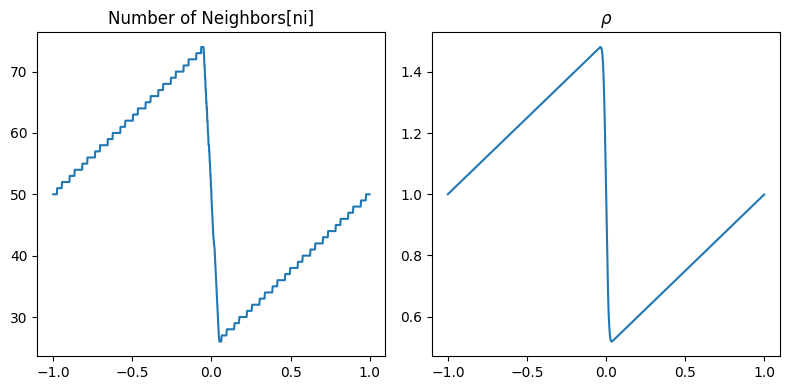

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def scatterPlot(fig, axis, p, c, domainMin, domainMax, label = None):
    # sc = axis.plot(p[:,0], c, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    sc = axis.plot(p[:,0], c)#, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)
        
fig, axis = plt.subplots(1, 2, figsize=(8,4), sharex = False, sharey = False, squeeze = False)
scatterPlot(fig, axis[0,0], particles, ni, minExtent, maxExtent, 'Number of Neighbors[ni]')

rho = sphOperation((areas, areas), (ones, ones), (ones, ones), (i, j), Wij, gradWij, xij, rij, hij, particles.shape[0], operation = 'interpolate')
# print(rho)

scatterPlot(fig, axis[0,1], particles, rho, minExtent, maxExtent, '$\\rho$')

fig.tight_layout()

In [ ]:
# No support for higher dimensions yet